In [1]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from DEICODE import untangle,fetch
#transforms 
from skbio.stats.composition import clr,ilr,centralize
#else
%matplotlib inline
# make the notebook readable
from IPython.core.display import HTML
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")

 Sponges (case study)

 A comprehensive analysis of microbial symbiont communities associated with 82 species from the phylum Porifera

 P.I.  Torsten Thomas (University of New South Wales)
 [Data and Source](https://qiita.ucsd.edu/study/description/10346)

First we import the .biom OTU table and tab delimited mapping file (qiime style).

In [84]:
map_file='data/benchmarking/Thomas_sponge_communities.txt' #import metadata
in_biom='data/benchmarking/Thomas_sponge_communities.biom' #import biom file
filter_count=100 # filtering could for biom file (useful for large datasets) 
otutabledf,mappingdf,taxnames=fetch.dfimport(in_biom,map_file,filter_count)

Next we will run supervised machine learning this will help us identify biologically relevant trends in the data quickly

In [73]:
# The main input is just the otu table and the mapping data. 
# complete will determine if you do completion (iteration is the number of iterations for the completion)
spongescores,sponge_low_rank_data=untangle.machine_learning(otutabledf,mappingdf.T,complete=True,iteration=100,mean_count=1,addtofilter=['adult'])

 Now we can visualize the output of the machine learning.

 The cross-validation scores give you a metric of how well each mapping category (i.e. metadata column) correlates to the taxonomic patterns in your data. For example here we see that life stage correlates the best with taxonomic trends.

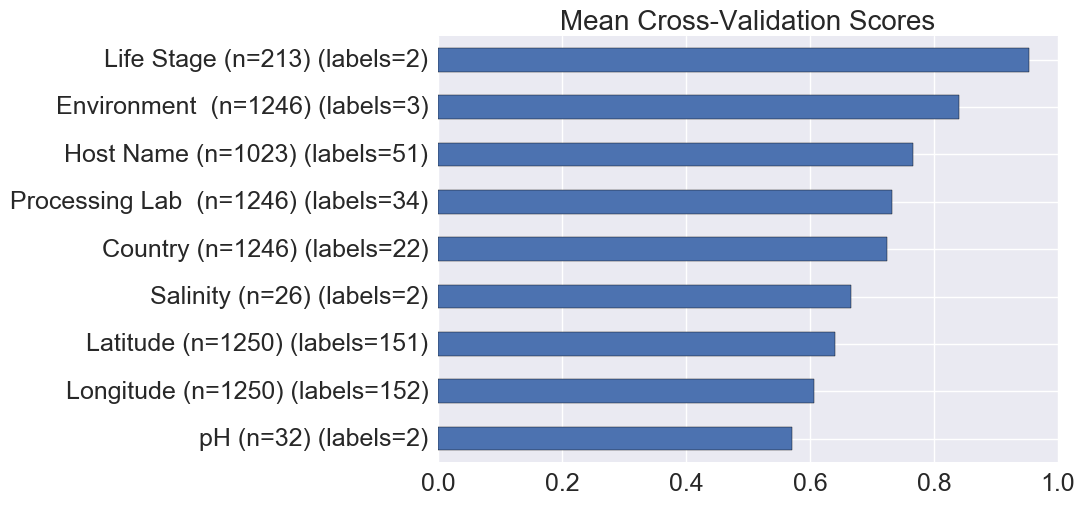

In [16]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
spongescores.columns=['Matrix Completion (RF)']
spongescores.sort_values(['Matrix Completion (RF)'], ascending = [True], inplace = True)
#rename a few
spongescores.loc[spongescores['Matrix Completion (RF)'] > .5].plot(kind='barh',fontsize=18,legend=False,xlim=(0,1),ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
plt.title('Mean Cross-Validation Scores',fontsize=20)
ax1.set_ylabel('')
plt.show()

To view how much better we can predict using matrix completion we can look and the confusion matrix for our best prediction, life stage. The accuracy measure is in the diagonal values, the closer it is to 1 the better (1 is the max).

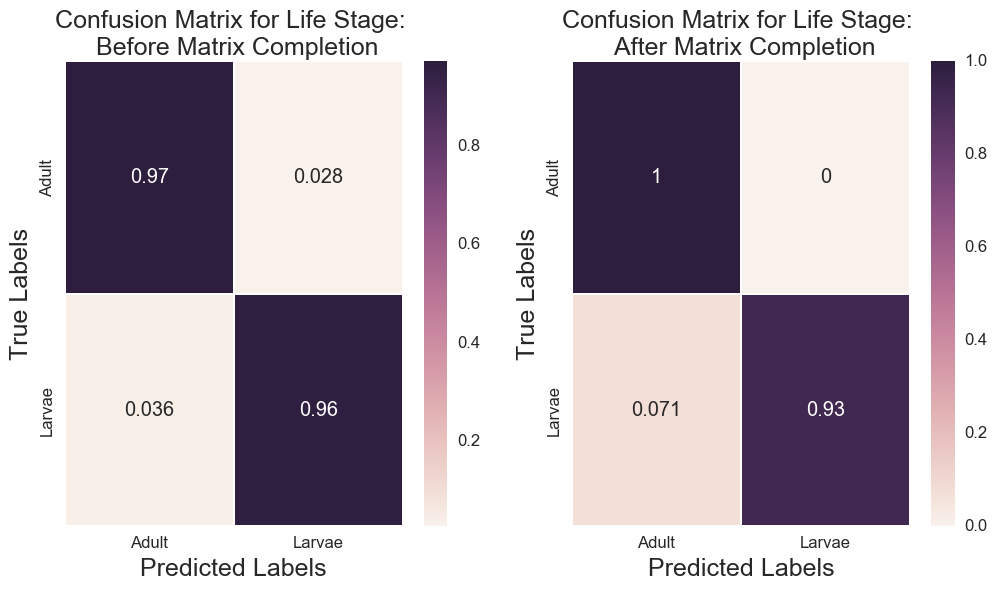

In [17]:
#get confusion matrix
niche='Life Stage'#this will determine which mapping catagory to use
orgconfuse=untangle.get_confusion(otutabledf,mappingdf.T[~mappingdf.T[niche].isin(['Unknown','adult'])],niche,.3)
lrconfuse=untangle.get_confusion(sponge_low_rank_data,mappingdf.T[~mappingdf.T[niche].isin(['Unknown','adult'])],niche,.3)

#plot
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6)) 
fntsizes=18
sns.set(font_scale=1.2)
sns.heatmap(orgconfuse, annot=True, linewidths=.5,ax=ax1)
ax1.set_title('Confusion Matrix for Life Stage: \n Before Matrix Completion',fontsize=fntsizes)
ax1.set_ylabel('True Labels',fontsize=fntsizes)
ax1.set_xlabel('Predicted Labels',fontsize=fntsizes)   
sns.heatmap(lrconfuse, annot=True, linewidths=.5,ax=ax2)
ax2.set_title('Confusion Matrix for Life Stage: \n After Matrix Completion',fontsize=fntsizes)
ax2.set_ylabel('True Labels',fontsize=fntsizes)
ax2.set_xlabel('Predicted Labels',fontsize=fntsizes)
plt.show()

As we can see we do indeed learn better after we complete the OTU table. 

Now we can extract OTUs (features) that separate sponges across life stages.

 Now that we know from the cross-validation scores that life stage is an important category we would like to find out what pattern of OTUs best explain this variation.  Here we plot the taxonomic pattern that the machine learning algorithm found to be most predictive for the sponge sample's life stage. The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.

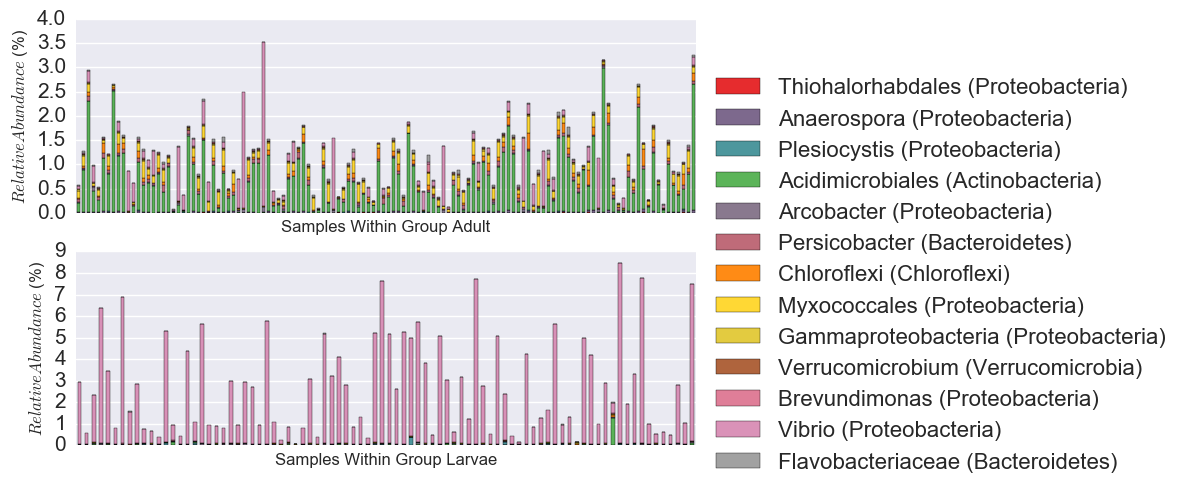

In [79]:
#get important features
n=13#this will be the number of OTUs that are in the figure 
sfotus,sfmappingdf=fetch.matchtable(sponge_low_rank_data,mappingdf.T[~mappingdf.T[niche].isin(['Unknown','adult'])].T)
important_otus=untangle.features_ml(sfotus,sfmappingdf.T,niche,complete=True,iteration=100)
#plot
fig=untangle.feature_vis(sfotus,sfmappingdf,list(important_otus.index[:n]),niche,taxnames)
plt.show()

 Here we find that the OTUs that best differentiate the samples between adult sponges and larvae are mostly in the phylum Proteobacteria. We can see that the Proteobacteria Marinomonas and Oceanospirillaceae are more abundant in adult sponges, while the larvae sponges have a diverse group of Proteobacteria and Chloroflexi that differentiate them.

Now we can view this pattern directly in the OTU table using biclustering, first we will write a simple plotting script allowing us to compare between before and after matrix completion

In [88]:
# we will use this as our simple plotting function
def plot_compare(otudata,mapping,catvis,titleadd='',hmax=6,fig_fontsize=18,isorg=True):
    
    #get the rank (equal to number of labels for metadata catagory)
    r=len(set(mapping.T[catvis].tolist()))
    #first we will take the bicluser 
    biploto,datatmp=untangle.biplot(otudata,r)
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 5)) 

    if titleadd!='':
        fig.suptitle('%s '%(titleadd),fontsize=fig_fontsize+4)

    sns.heatmap(otudata,xticklabels=False, yticklabels=False,robust=True,ax=ax1)
    ax1.set_title('OTU Table\n',fontsize=fig_fontsize)    
    ax1.set_ylabel('OTUs',fontsize=fig_fontsize-2)
    ax1.set_xlabel('Samples',fontsize=fig_fontsize-2)

    sns.heatmap(biploto,xticklabels=False, yticklabels=False,robust=True,ax=ax2)
    ax2.set_title('Spectral Coclustering \n',fontsize=fig_fontsize)    
    ax2.set_ylabel('OTUs',fontsize=fig_fontsize-2)
    ax2.set_xlabel('Samples',fontsize=fig_fontsize-2)

    untangle._scatter(ax3,untangle.reduce_plot(otudata,mapping,catvis,method='PCoA',reduce_only=True),catvis)
    ax3.set_title('PCoA (bray-curtis) \n',fontsize=fig_fontsize)
    ax3.set_ylabel('$PC-1$',fontsize=fig_fontsize-2)
    ax3.set_xlabel('$PC-2$',fontsize=fig_fontsize-2)    

    plt.tight_layout()
    fig.subplots_adjust(top=.78)

    return biploto

Now we will perform PCoA and biclustering for the OTU table before and after matrix completion 

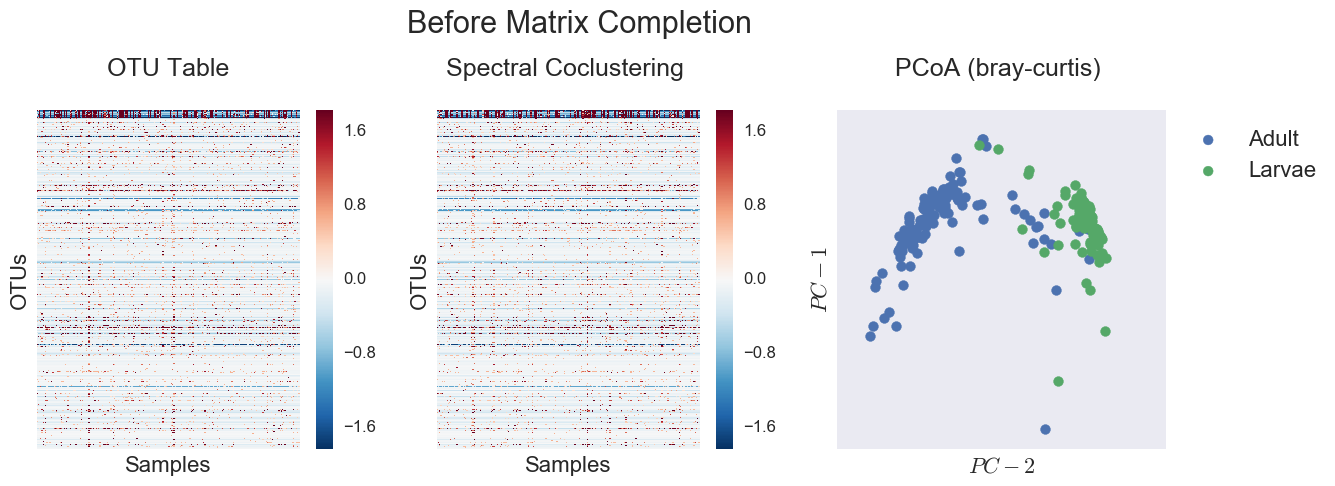

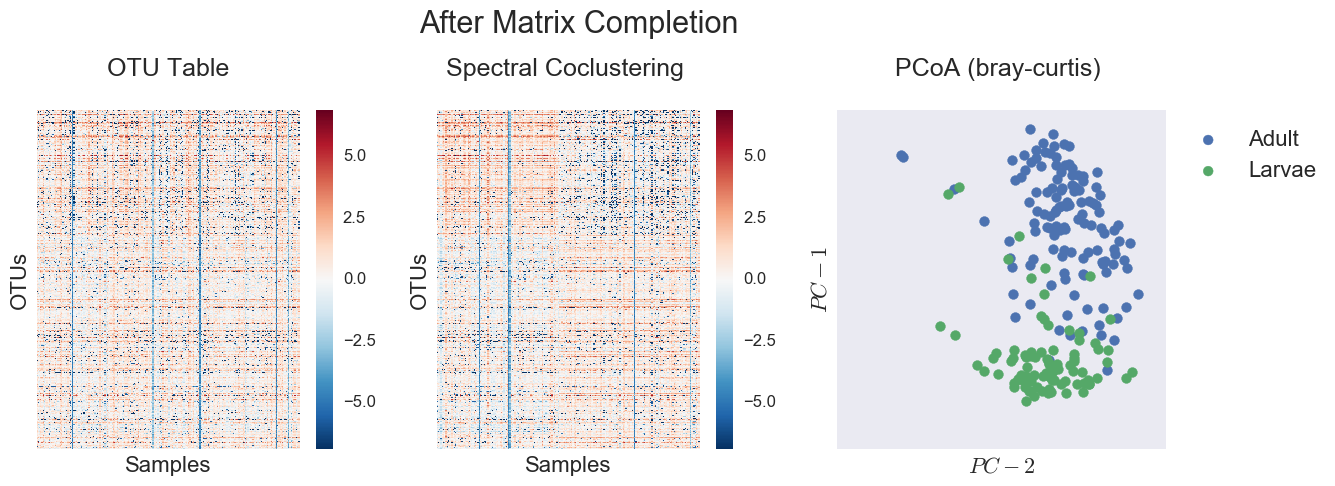

In [89]:
otutabledfclr,mappingdf2=fetch.matchtable(pd.DataFrame(clr(otutabledf+1),columns=otutabledf.columns,index=otutabledf.index),mappingdf.T[~mappingdf.T[niche].isin(['Unknown','adult'])].T)
#plot biplot comparison 
biplotorg=plot_compare(otutabledfclr,mappingdf2,niche,titleadd='Before Matrix Completion ',isorg=True)
plt.show()

#complete and take clr 
completed=pd.DataFrame(clr(untangle.complete_matrix(otutabledf.as_matrix().copy(),iteration=300,minval=1e-3)),columns=otutabledf.columns,index=otutabledf.index)   
#plot biplots comparison 
lrotutabledfclr,mappingdf2=fetch.matchtable(completed,mappingdf.T[~mappingdf.T[niche].isin(['Unknown','adult'])].T)
biplotlr=plot_compare(lrotutabledfclr,mappingdf2,niche,titleadd='After Matrix Completion ')
plt.show()

Finally, we can see that indeed we can sort the OTUs into the repective groups. This can be increibly power because you can start to vuew each cluster as community specfiic to different enviornments. 

[Next Example](https://github.com/cjm007/DEICODE/blob/master/Examples/infant_biom.ipynb)